In [40]:
## Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import os

In [41]:
## Preprocessed time serie from Energy Solar consumption
filename = "monthdata.csv"
output_data = "../../data/output"
filepath = os.path.join(output_data,filename)

In [42]:
months = pd.read_csv(filepath,index_col=False, header=0)
months.head()

,YYYYMM,Value
0,198901,2.798
1,198902,3.016
2,198903,4.156
3,198904,4.581
4,198905,5.057


In [43]:
# convert into real dates, set as index for time series
months['dates'] = pd.to_datetime(months["YYYYMM"], format="%Y%m")
timeserie = months[['dates','Value']]
timeserie = timeserie.set_index('dates')
print("Total Observations " ,len(timeserie))
timeserie.head()

Total Observations  351


,Value
dates,
1989-01-01,2.798
1989-02-01,3.016
1989-03-01,4.156
1989-04-01,4.581
1989-05-01,5.057


## Time series exploration

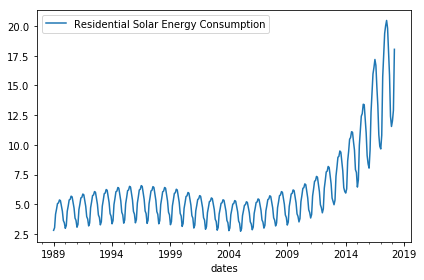

In [45]:
timeserie.plot()
plt.legend(['Residential Solar Energy Consumption'], loc='best')
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/timeserie.png")
plt.show()
plt.show()

/anaconda3/envs/PythonData_3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


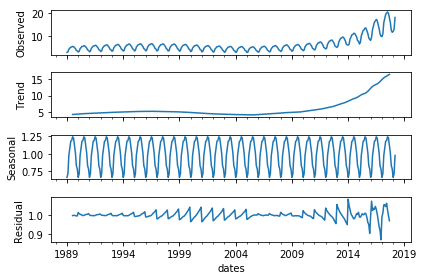

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(timeserie, model='multiplicative', freq= 12)
result.plot()
# Save the figure
plt.savefig('../../images/Decomposetimeserie.png')
plt.show()

### Exploring data correalation

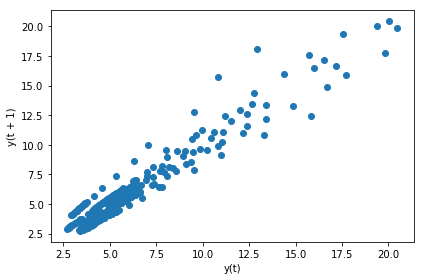

In [7]:
from pandas.plotting import lag_plot
lag_plot(timeserie)
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/lag_plot.png")
plt.show()

###  statistical test the Pearson correlation coefficient. 

In [8]:
values = pd.DataFrame(timeserie.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

         t-1      t+1
t-1  1.00000  0.96359
t+1  0.96359  1.00000


### Autocorrelation plots

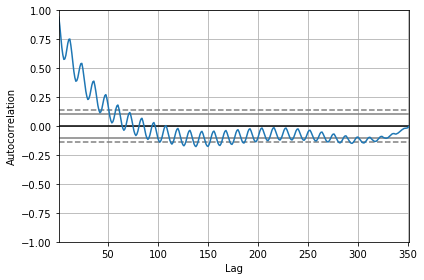

In [9]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(timeserie)
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/autocorr.png")
plt.show()

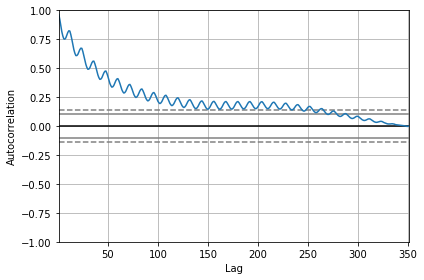

In [10]:
from pandas.plotting import autocorrelation_plot
import numpy as np
normalized_timeserie = timeserie.copy()
normalized_timeserie['newvalue'] = np.log1p(timeserie['Value'])
autocorrelation_plot(normalized_timeserie)
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/autocorr.png")
plt.show()

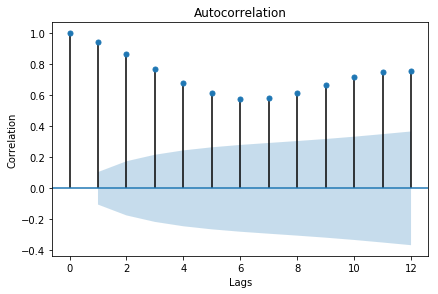

In [11]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(timeserie, lags=12)
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/acf.png")
plt.ylabel("Correlation")
plt.xlabel("Lags")
plt.show()

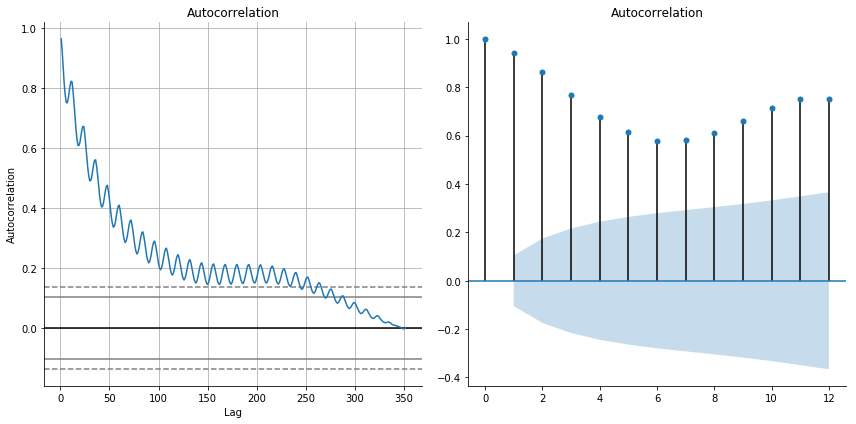

In [12]:
fig1 = plt.figure(figsize=(12, 6))
axes1 = fig1.add_subplot(1, 2, 1)
axes2 = fig1.add_subplot(1, 2, 2)

axes1.set_title("Autocorrelation")
axes2.set_title("Lag correlation")

# axes1.set_xlim(-maxx + 1, maxx + 1)
# axes1.set_ylim(-maxy + 1, maxy + 1)

# axes2.set_xlim(-2, 2)
# axes2.set_ylim(-2, 2)

def set_axes(ax):
    #ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    #ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
set_axes(axes1)
set_axes(axes2)

autocorrelation_plot(normalized_timeserie, ax = axes1)

plot_acf(timeserie, lags=12, ax = axes2)

# Save our graph 
plt.tight_layout()
plt.savefig("../../images/timeseriesautocorrelation.png")
plt.show()


## Persistence Model

The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

We can develop a test harness for the problem by splitting the observations into training and test sets, with only the last 2 observations in the dataset assigned to the test set as “unseen” data that we wish to predict.

Test MSE: 13.598


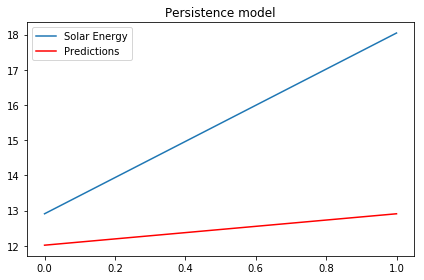

In [30]:
series = timeserie
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = pd.DataFrame(series.values)
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-2], X[len(X)-2:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in X_test:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(y_test, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(y_test)
plt.plot(predictions, color='red')
plt.legend(['Solar Energy','Predictions'], loc='best')
plt.title("Persistence model")
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/model_persistence.png")
plt.show()

### Adding Scaling 

In [31]:
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(X_train.reshape(-1, 1))
y_scaler = StandardScaler().fit(y_train.reshape(-1, 1))

In [32]:
X_train_scaled = X_scaler.transform(X_train.reshape(-1, 1))
X_test_scaled = X_scaler.transform(X_test.reshape(-1, 1))
y_train_scaled = y_scaler.transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1, 1))

Test MSE: 1.376


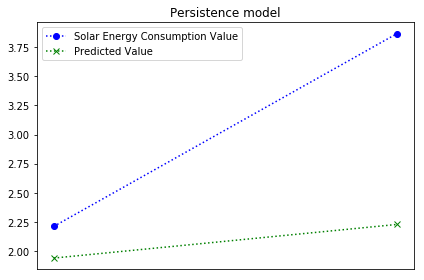

In [39]:
# persistence model
def model_persistence(x):
	return x

# walk-forward validation
predictions = list()
for x in X_test_scaled:
	yhat = model_persistence(x)
	predictions.append(yhat)
test_score = mean_squared_error(y_test_scaled, predictions)
print('Test MSE: %.3f' % test_score)
# plot predictions vs expected
plt.plot(y_test_scaled,color ='blue', marker='o', linestyle='dotted')
plt.plot(predictions, color='green',marker='x', linestyle='dotted' )
plt.legend(['Solar Energy Consumption Value','Predicted Value'], loc='best')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
# Save our graph 
plt.title("Persistence model")
plt.tight_layout()
plt.savefig("../../images/model_persistence.png")
plt.show()

## Autoregression Model

An autoregression model is a linear regression model that uses lagged variables as input variables. This creates 1 12-month(year) forecast, which is different from the persistence example above.

train observations  338 test observations:  12
Lag: 16
Coefficients: [ 0.03637337  1.04449049  0.01577134 -0.21210531 -0.08595507  0.08453611
 -0.08232884  0.09039772 -0.0544828   0.05397536 -0.03146968  0.07923267
  0.95338273 -0.99801893 -0.08173138  0.29174056  0.01128384]
predicted=4.931478, expected=4.778201
predicted=5.835609, expected=5.506196
predicted=6.200992, expected=5.768613
predicted=6.474579, expected=5.948798
predicted=6.256206, expected=5.685575
predicted=5.346708, expected=4.841487
predicted=4.618008, expected=4.083663
predicted=3.490397, expected=2.697005
predicted=3.067429, expected=2.347922
predicted=2.998096, expected=2.536975
predicted=3.615863, expected=2.896942
predicted=5.799104, expected=4.968060
Test MSE: 0.336


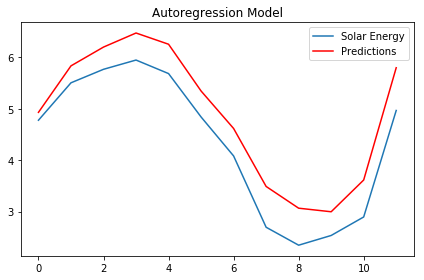

In [20]:
from statsmodels.tsa.ar_model import AR
# split dataset
X = series.values
train, test = X[1:len(X)-12], X[len(X)-12:]
print("train observations ", len(train), "test observations: ",len(test))
# scale
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(train.reshape(-1, 1))
train_scaled = X_scaler.transform(train.reshape(-1, 1))
test_scaled = X_scaler.transform(test.reshape(-1, 1))
# train autoregression
model = AR(train_scaled)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train_scaled), end=len(train_scaled)+len(test_scaled)-1, dynamic=False)
for i in range(len(predictions)):
	print('predicted=%f, expected=%f' % (predictions[i], test_scaled[i]))
error = mean_squared_error(test_scaled, predictions)
print('Test MSE: %.3f' % error)
# plot results
plt.plot(test_scaled)
plt.plot(predictions, color='red')
plt.legend(['Solar Energy','Predictions'], loc='best')
plt.title("Autoregression Model")
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/ARmodel.png")
plt.show()

## Autoregression with re-training 

An alternative would be to use the learned coefficients and manually make predictions. This requires that the history of 16 prior observations be kept and that the coefficients be retrieved from the model and used in the regression equation to come up with new forecasts.


train observations  338 test observations:  12
AR model params window 16, coef [ 0.03637337  1.04449049  0.01577134 -0.21210531 -0.08595507  0.08453611
 -0.08232884  0.09039772 -0.0544828   0.05397536 -0.03146968  0.07923267
  0.95338273 -0.99801893 -0.08173138  0.29174056  0.01128384]
History for re-training:  16
predicted=4.931478, expected=4.778201
predicted=5.675513, expected=5.506196
predicted=5.854506, expected=5.768613
predicted=6.050279, expected=5.948798
predicted=5.783259, expected=5.685575
predicted=4.849464, expected=4.841487
predicted=4.214768, expected=4.083663
predicted=3.067250, expected=2.697005
predicted=2.356243, expected=2.347922
predicted=2.356465, expected=2.536975
predicted=3.304432, expected=2.896942
predicted=5.210102, expected=4.968060
Test MSE: 0.041


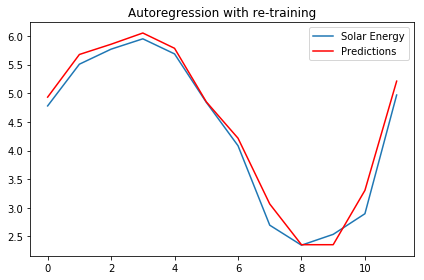

In [21]:
# split dataset
X = series.values
train, test = X[1:len(X)-12], X[len(X)-12:]
print("train observations ", len(train), "test observations: ",len(test))
# scale
from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler().fit(train.reshape(-1, 1))
train_scaled = X_scaler.transform(train.reshape(-1, 1))
test_scaled = X_scaler.transform(test.reshape(-1, 1))

# train autoregression
model = AR(train_scaled)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params
print(f"AR model params window {window}, coef {coef}")
# walk forward over time steps in test
history = train_scaled[len(train_scaled)-window:]
print("History for re-training: ",len(history))
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_scaled)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test_scaled[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_scaled, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test_scaled)
plt.plot(predictions, color='red')
plt.legend(['Solar Energy','Predictions'], loc='best')
plt.title("Autoregression with re-training")
# Save our graph 
plt.tight_layout()
plt.savefig("../../images/ARmodel_history.png")
plt.show()

In [24]:
dataAR = np.append(train_scaled, predictions)
dataAR

array([-1.09090896e+00, -6.31377007e-01, -4.60060271e-01, -2.68185527e-01,
       -2.50046108e-01, -1.47659165e-01, -1.69829566e-01, -3.57673328e-01,
       -5.30602456e-01, -8.49856232e-01, -9.23623203e-01, -1.11146696e+00,
       -1.01835128e+00, -5.31811751e-01, -3.50417560e-01, -1.47256066e-01,
       -1.27504255e-01, -1.90708383e-02, -4.28536322e-02, -2.41984144e-01,
       -4.24990727e-01, -7.63190119e-01, -8.41391170e-01, -1.07397883e+00,
       -9.78041460e-01, -4.75781101e-01, -2.88743535e-01, -7.91324703e-02,
       -5.89775603e-02,  5.26806416e-02,  2.84947495e-02, -1.77085333e-01,
       -3.65735292e-01, -7.14415236e-01, -7.95437975e-01, -1.02963803e+00,
       -9.30072774e-01, -4.10076094e-01, -2.16588957e-01,  6.80973589e-04,
        2.16420801e-02,  1.37331264e-01,  1.11936077e-01, -1.00496675e-01,
       -2.95999303e-01, -6.57175292e-01, -7.41019718e-01, -9.93762290e-01,
       -8.91375347e-01, -3.56867131e-01, -1.57333521e-01,  6.59828823e-02,
        8.73470870e-02,  

In [32]:
dfAR = pd.DataFrame(dataAR)

In [33]:
len(dfAR)

350

In [35]:
dataname = "dfAR.csv"
filesave = os.path.join(output_data,dataname)
dfAR.to_csv(filesave, index=False)